In [1]:
!nvidia-smi # Make sure you get a Tesla P100 or T4. Otherwise, factory reset runtime.

Thu Nov 12 14:48:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#TO TRY: Choose a different starting net
#base_model = keras.applications.ResNet50(weights='imagenet', include_top=False)
base_model = keras.applications.Xception(weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [4]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [5]:
base_model.trainable = False #Will set trainable parameters to 0
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [6]:
train_ds, val_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    shuffle_files = True,
    split=["train[:80%]", "train[80%:95%]", "train[95%:100%]"], # 80-15-5 train-val
    as_supervised=True,  # Include labels
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteTWJNXR/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


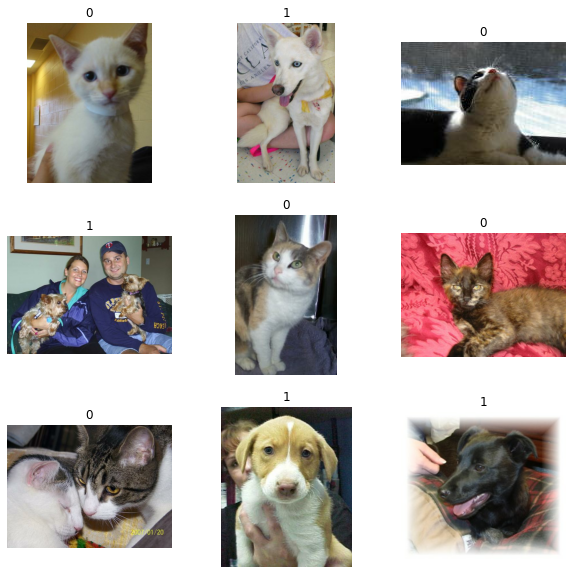

In [7]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [8]:
tf.data.experimental.cardinality(train_ds), tf.data.experimental.cardinality(val_ds), tf.data.experimental.cardinality(test_ds)

(<tf.Tensor: shape=(), dtype=int64, numpy=18610>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3489>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1163>)

In [9]:
size = (299, 299) #IF you change this you need to change input shape below
batch_size = 64 #TO TRY: increase..if Out-of-Memory (OOM), then reduce to 32

def process_ds(ds):
    return ds.map(lambda x, y: (tf.image.resize(x, size), y)).batch(batch_size).prefetch(buffer_size=1)

train_ds = process_ds(train_ds)
val_ds = process_ds(val_ds)
test_dse = process_ds(test_ds)

In [10]:
#TO TRY: Different preprocessings in the package
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

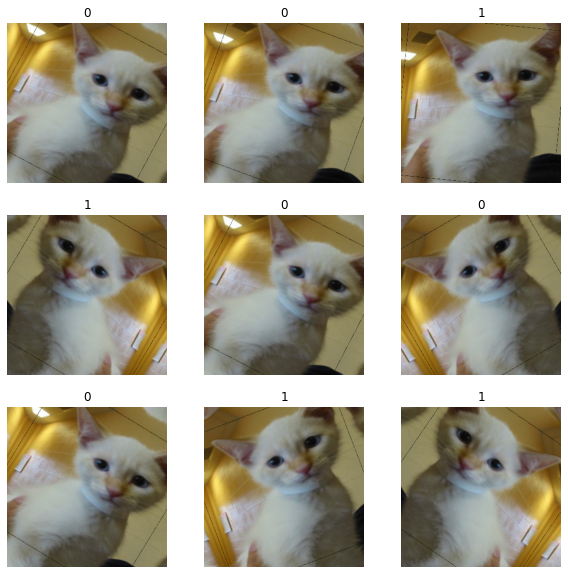

In [11]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [12]:
inputs = keras.Input(shape=(299, 299, 3)) #IF you change this you need to change size above, ToTry: change to 299
norm_layer = layers.experimental.preprocessing.Normalization()
mean = np.array([255 / 2.0] * 3) #To try: make true mean and var
var = mean ** 2 # this is not really variance, it just normalizes the pixels to the range of [0, 1]

In [13]:
x = data_augmentation(inputs)
x = norm_layer(x)
norm_layer.set_weights([mean, var])

In [14]:
x = base_model(x, training=False) # training=False since the base model is frozen
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 299, 299, 3)       7         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True), # since the last Dense layer has no activation
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [16]:
epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
291/291 [==============================] - 93s 321ms/step - loss: 0.1095 - binary_accuracy: 0.9643 - val_loss: 0.0372 - val_binary_accuracy: 0.9923
Epoch 2/10
291/291 [==============================] - 92s 316ms/step - loss: 0.0351 - binary_accuracy: 0.9912 - val_loss: 0.0282 - val_binary_accuracy: 0.9920
Epoch 3/10
291/291 [==============================] - 92s 316ms/step - loss: 0.0288 - binary_accuracy: 0.9913 - val_loss: 0.0250 - val_binary_accuracy: 0.9920
Epoch 4/10
291/291 [==============================] - 92s 315ms/step - loss: 0.0269 - binary_accuracy: 0.9911 - val_loss: 0.0248 - val_binary_accuracy: 0.9920
Epoch 5/10
291/291 [==============================] - 92s 316ms/step - loss: 0.0244 - binary_accuracy: 0.9926 - val_loss: 0.0238 - val_binary_accuracy: 0.9923
Epoch 6/10
291/291 [==============================] - 92s 316ms/step - loss: 0.0245 - binary_accuracy: 0.9923 - val_loss: 0.0229 - val_binary_accuracy: 0.9928
Epoch 7/10
291/291 [==========================

In [17]:
base_model.trainable = True
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 299, 299, 3)       7         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [18]:
#IF YOU GET OOM:

train_ds, val_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    shuffle_files = True,
    split=["train[:80%]", "train[80%:95%]", "train[95%:100%]"], # 80-15-5 train-val
    as_supervised=True,  # Include labels
)
batch_size = 32

train_ds = process_ds(train_ds)
val_ds = process_ds(val_ds)
test_dse = process_ds(test_ds)


In [19]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
  2/582 [..............................] - ETA: 3:38 - loss: 0.0377 - binary_accuracy: 0.9844WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1632s vs `on_train_batch_end` time: 0.5897s). Check your callbacks.


582/582 [==============================] - 456s 783ms/step - loss: 0.0199 - binary_accuracy: 0.9934 - val_loss: 0.0183 - val_binary_accuracy: 0.9934
Epoch 2/10
582/582 [==============================] - 456s 783ms/step - loss: 0.0101 - binary_accuracy: 0.9968 - val_loss: 0.0198 - val_binary_accuracy: 0.9940
Epoch 3/10
582/582 [==============================] - 456s 783ms/step - loss: 0.0082 - binary_accuracy: 0.9969 - val_loss: 0.0174 - val_binary_accuracy: 0.9951
Epoch 4/10
582/582 [==============================] - 456s 784ms/step - loss: 0.0064 - binary_accuracy: 0.9979 - val_loss: 0.0212 - val_binary_accuracy: 0.9948
Epoch 5/10
582/582 [==============================] - 457s 785ms/step - loss: 0.0043 - binary_accuracy: 0.9984 - val_loss: 0.0181 - val_binary_accuracy: 0.9948
Epoch 6/10
582/582 [==============================] - 456s 783ms/step - loss: 0.0046 - binary_accuracy: 0.9984 - val_loss: 0.0202 - val_binary_accuracy: 0.9951
Epoch 7/10
582/582 [==============================]